In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from scipy.io import loadmat
from torch.utils.data import TensorDataset, DataLoader

data = loadmat('/content/gdrive/MyDrive/Data/MNIST_digit.mat')
x_train = data['X_train'].reshape(60000, 784)
y_train = data['y_train'].squeeze()
x_test = data['X_test'].reshape(10000, 784)
y_test = data['y_test'].squeeze()

x_mean = x_train.mean(axis = 0)
x_std = x_train.std(axis = 0)
x_train = (x_train - x_mean) / x_std
x_test = (x_test - x_mean) / x_std

x_train = torch.FloatTensor(x_train)
y_train = torch.LongTensor(y_train)
x_test = torch.FloatTensor(x_test)
y_test = torch.LongTensor(y_test)

train_loader = DataLoader(TensorDataset(x_train, y_train), batch_size = 128, shuffle = True)

In [ ]:
## 1-(a)
class LogisticRegression(nn.Module):
  def __init__(self, x_size, num_class):
    super(LogisticRegression, self).__init__()
    self.linear = nn.Linear(x_size, num_class)

  def forward(self, x):
    return self.linear(x)

  def pred_prob(self, x):
    logit = self.forward(x)
    return torch.softmax(logit, dim = 1)

  def predict(self, x):
    logit = self.forward(x)
    _, pred = torch.max(logit, dim = 1)
    return pred

model = LogisticRegression(784, 10)
lossf = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.5, patience = 2)

num_epoch = 100
train_loss = []
train_error = []
test_error = []
for i in range(num_epoch):
  model.train()
  current_loss = 0
  for x, y in train_loader:
    optimizer.zero_grad()
    pred = model(x)
    loss = lossf(pred, y)
    loss.backward()
    optimizer.step()
    current_loss += loss.item()
  epoch_loss = current_loss / len(train_loader)
  train_loss.append(epoch_loss)

  model.eval()
  with torch.no_grad():
    _, train_pred = torch.max(model(x_train), 1)
    train_error.append((train_pred != y_train).float().mean().item())
    _, test_pred = torch.max(model(x_test), 1)
    test_error.append((test_pred != y_test).float().mean().item())
  scheduler.step(epoch_loss)

print(f'Final training misclassification error: {train_error[-1]:.4f}')
print(f'Final test misclassification error: {test_error[-1]:.4f}')

Final training misclassification error: 0.0571
Final test misclassification error: 0.0745


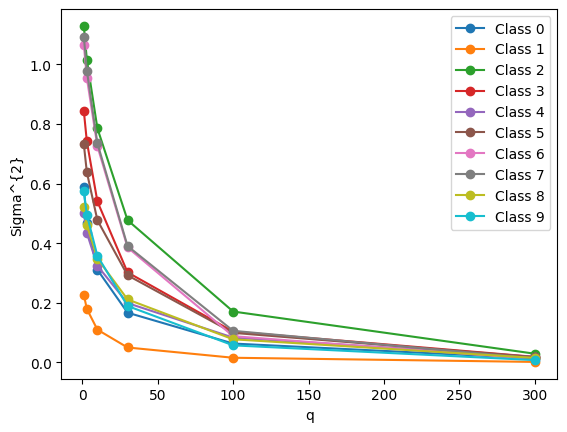

In [ ]:
## 1-(b)
from sklearn.decomposition import PCA

q_values = [1, 3, 10, 30, 100, 300]
noise_var = np.zeros((10, len(q_values)))
models = {}

for cls in range(10):
  x_sub = x_train[y_train == cls]
  models[cls] = {}
  for i, q in enumerate(q_values):
    pca = PCA(n_components = q)
    pca.fit(x_sub)
    mu = pca.mean_
    W = pca.components_.T * np.sqrt(pca.explained_variance_ - pca.noise_variance_)
    models[cls][q] = (mu, W, pca.noise_variance_)
    noise_var[cls, i] = pca.noise_variance_
  plt.plot(q_values, noise_var[cls], marker = 'o', label = f'Class {cls}')
plt.xlabel('q')
plt.ylabel('Sigma^{2}')
plt.legend()
plt.show()

In [ ]:
## 1-(c)
from scipy.linalg import inv

def mahal(x, mu, W, sigma2, q):
  xcent = x - mu
  if q == 0:
    return np.sum(xcent**2, axis = 1)
  if q == 784:
    return np.einsum('ij,jk,ik->i', xcent, inv(W), xcent)
  term1 = np.sum(xcent**2, axis = 1) / sigma2
  WTx = np.dot(W.T, xcent.T)
  M = np.eye(W.shape[1]) + np.dot(W.T, W) / sigma2
  term2 = np.zeros(x.shape[0])
  for i in range(x.shape[0]):
    term2[i] = np.dot(WTx[:, i], np.dot(inv(M), WTx[:, i])) / (sigma2**2)
  return term1 - term2

def assign(x, model, q):
  dist = np.zeros((x.shape[0], 10))
  for i in range(10):
    mu, W, sigma2 = model[i][q]
    dist[:, i] = mahal(x, mu, W, sigma2, q)
  return np.argmin(dist, axis = 1)

data = loadmat('/content/gdrive/MyDrive/Data/MNIST_digit.mat')
x_train = data['X_train'].reshape(60000, 784)
y_train = data['y_train'].squeeze()
x_test = data['X_test'].reshape(10000, 784)
y_test = data['y_test'].squeeze()

x_mean = x_train.mean(axis = 0)
x_std = x_train.std(axis = 0)
x_train = (x_train - x_mean) / x_std
x_test = (x_test - x_mean) / x_std

for i in range(10):
  x_sub = x_train[y_train == i]
  mu = np.mean(x_sub, axis = 0)
  models[i][0] = (mu, None, 1)
  models[i][784] = (mu, np.cov(x_sub, rowvar = False), None)

q_values = [0, 1, 3, 10, 30, 100, 300, 784]
train_error = []
test_error = []
for i, q in enumerate(q_values):
  train_error.append(np.mean(assign(x_train, models, q) != y_train))
  test_error.append(np.mean(assign(x_test, models, q) != y_test))
  print(f"q = {q}, Train error: {train_error[i]:.4f}, Test error: {test_error[i]:.4f}")

q = 0, Train error: 0.9025, Test error: 0.9026
q = 1, Train error: 0.5429, Test error: 0.5392
q = 3, Train error: 0.4975, Test error: 0.4913
q = 10, Train error: 0.4292, Test error: 0.4169
q = 30, Train error: 0.2595, Test error: 0.2507
q = 100, Train error: 0.1481, Test error: 0.1556
